# Summary

This notebook shows an implementation of the algorithm Isolation Forest and compares its other popular anomaly detection algorithms

Take the case of identifying the probability of an employee committing securities fraud. Here the behavioral data that the organization captures is very high dimensional and the relationship between the data points is complex. Hence without indepth domain knowledge, formulating risk rules is difficult. This combined with issues such as confidentiality makes it very hard to validate these risk rules.

This is where unsupervised learning shines. With very little domain knowledge, a simple unsupervised algorithm can be used to create a list of anomalies which can then be fed into an auditing process which then generates the true labels. Over time when enough data labels are created, the unsupervised problem can be reformulated as a supervised ML problem.

My personal summary of why to use supervised here:

Exploratory Data Analysis: Unsupervised learning can help you understand the structure or patterns within your data.

Anomaly Detection: Unsupervised learning is useful for detecting anomalies or unusual patterns in data, where you don't necessarily have labeled examples of what constitutes an anomaly

Pattern Discovery: If you want to uncover hidden patterns or relationships in your data without specific goals, unsupervised learning can be beneficial.

THE END GOAL IS TO USE THIS TO DETECT FRAUD ANOMALIES WITHOUT ANY LABELED DATA

In [66]:
import pandas as pd # IMPORTS
import matplotlib.pyplot as plt
import numpy as np

from sklearn.ensemble import IsolationForest
from sklearn.metrics import f1_score
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score

%matplotlib inline

In [41]:
bankDF = pd.read_csv("../Base.csv") # Utilize the dataset that best represents the original dataset
y_true = bankDF['fraud_bool']
bankDF.head()

,fraud_bool,income,name_email_similarity,prev_address_months_count,current_address_months_count,customer_age,days_since_request,intended_balcon_amount,payment_type,zip_count_4w,...,has_other_cards,proposed_credit_limit,foreign_request,source,session_length_in_minutes,device_os,keep_alive_session,device_distinct_emails_8w,device_fraud_count,month
0,0,0.3,0.986506,-1,25,40,0.006735,102.453711,AA,1059,...,0,1500.0,0,INTERNET,16.224843,linux,1,1,0,0
1,0,0.8,0.617426,-1,89,20,0.010095,-0.849551,AD,1658,...,0,1500.0,0,INTERNET,3.363854,other,1,1,0,0
2,0,0.8,0.996707,9,14,40,0.012316,-1.490386,AB,1095,...,0,200.0,0,INTERNET,22.730559,windows,0,1,0,0
3,0,0.6,0.475100,11,14,30,0.006991,-1.863101,AB,3483,...,0,200.0,0,INTERNET,15.215816,linux,1,1,0,0
4,0,0.9,0.842307,-1,29,40,5.742626,47.152498,AA,2339,...,0,200.0,0,INTERNET,3.743048,other,0,1,0,0


# Data Cleaning

Any NaNs? Any 0s that shouldn't be there?

In [6]:
bankDF.isna().any().any() # Clean data set, to be expected since it was synthetically generated

False

In [7]:
bankDF.dtypes

fraud_bool                            int64
income                              float64
name_email_similarity               float64
prev_address_months_count             int64
current_address_months_count          int64
customer_age                          int64
days_since_request                  float64
intended_balcon_amount              float64
payment_type                         object
zip_count_4w                          int64
velocity_6h                         float64
velocity_24h                        float64
velocity_4w                         float64
bank_branch_count_8w                  int64
date_of_birth_distinct_emails_4w      int64
employment_status                    object
credit_risk_score                     int64
email_is_free                         int64
housing_status                       object
phone_home_valid                      int64
phone_mobile_valid                    int64
bank_months_count                     int64
has_other_cards                 

# Data Visualization

Take a closer look to see what we're dealing with

In [8]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

%matplotlib inline

<AxesSubplot: ylabel='Frequency'>

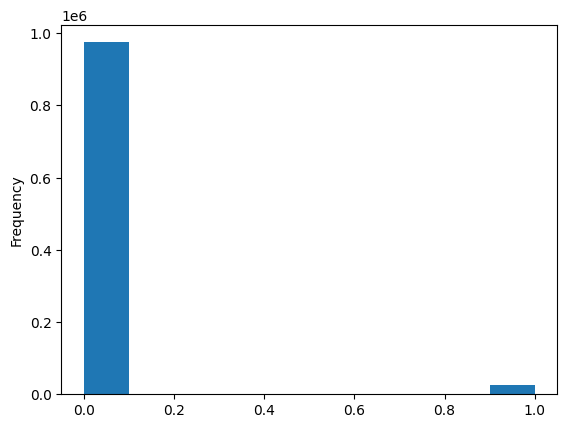

In [9]:
bankDF.foreign_request.plot.hist() # Seems to be very few foreign request, could be a sign of anomaly

<AxesSubplot: ylabel='Frequency'>

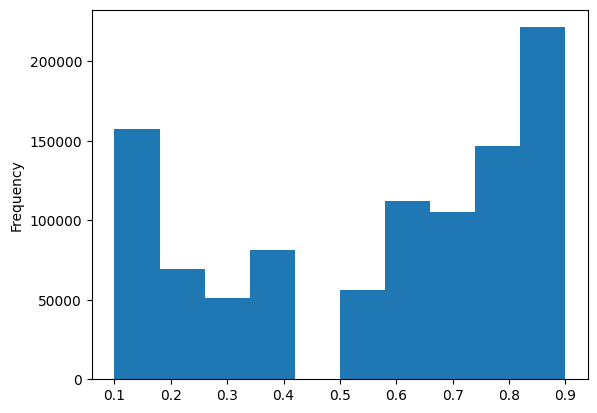

In [10]:
bankDF.income.plot.hist() # Not much to say here in terms of anomaly. Strange that a dataset this large is missing a bucket for a certain salary range though

<AxesSubplot: ylabel='Frequency'>

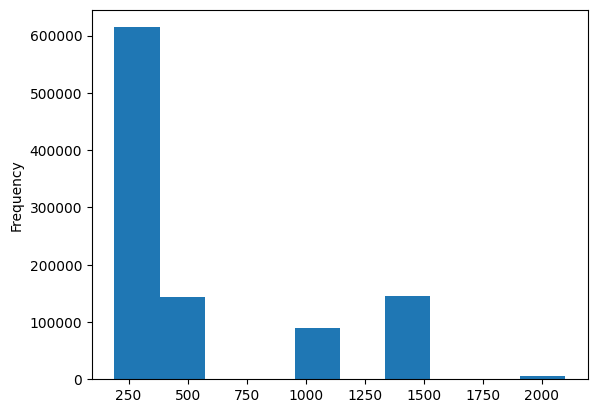

In [11]:
bankDF.proposed_credit_limit.plot.hist()

<AxesSubplot: >

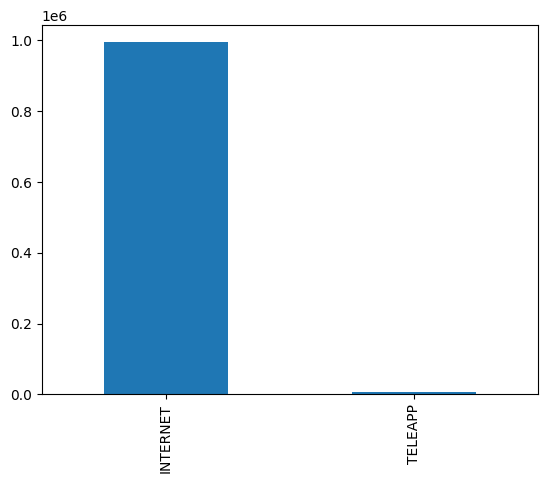

In [12]:
bankDF['source'].value_counts().plot(kind='bar') # Teleapp seems to be a VERY small minority, it's an anomaly but might not be fraud

<AxesSubplot: >

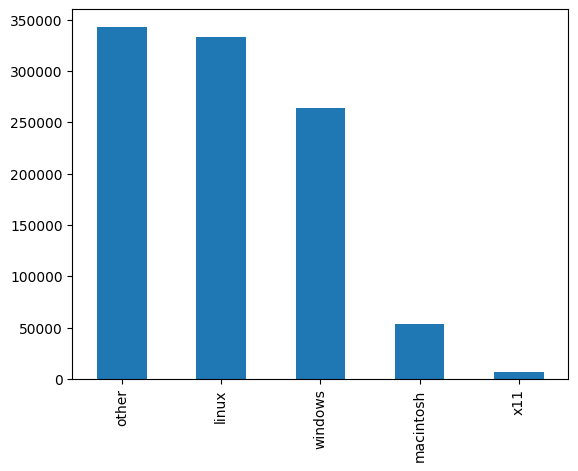

In [13]:
bankDF['device_os'].value_counts().plot(kind='bar') # Probably won't use this as a feature because it may just reflect popularity of a system rather than fraud

<AxesSubplot: ylabel='Frequency'>

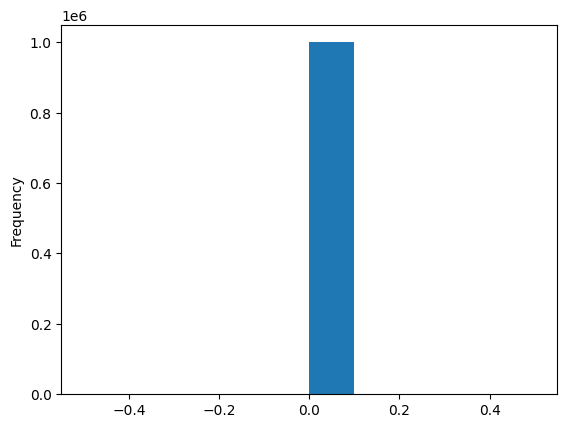

In [14]:
bankDF.device_fraud_count.plot.hist() # All at 0 as expected, if a device was flagged for fraud before then it's obvious

<AxesSubplot: ylabel='Frequency'>

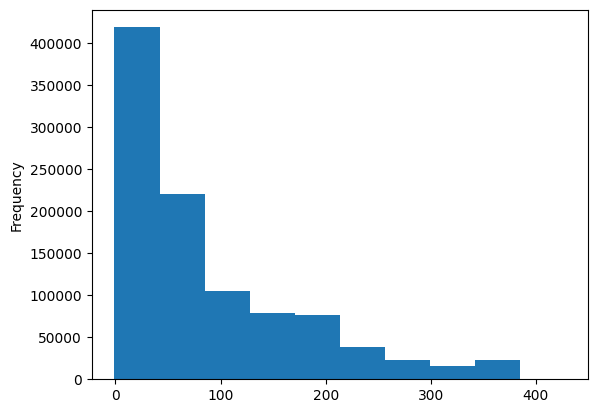

In [15]:
bankDF.current_address_months_count.plot.hist()

<AxesSubplot: ylabel='Frequency'>

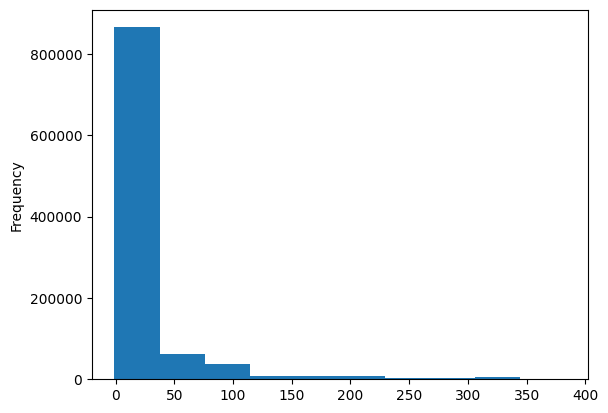

In [16]:
bankDF.prev_address_months_count.plot.hist()

Text(0, 0.5, 'Frequency')

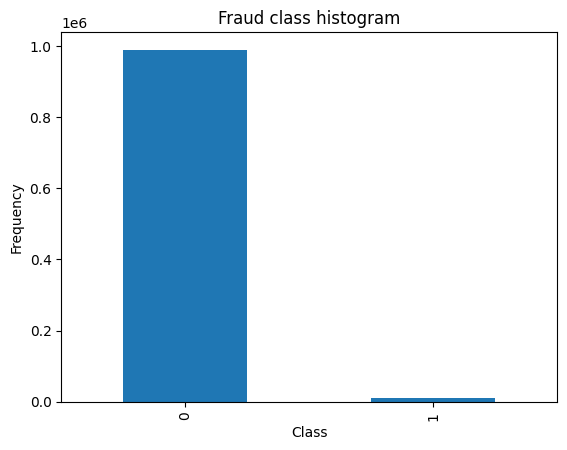

In [17]:
bankDF['fraud_bool'].value_counts().plot(kind='bar') # Very small portion of the data are fraud, makes sense since you wouldn't expect a large amount of a bank's applicants to be up to no good

plt.title("Fraud class histogram")
plt.xlabel("Class")
plt.ylabel("Frequency")

In [18]:
bankDF['fraud_bool'].value_counts()

0    988971
1     11029
Name: fraud_bool, dtype: int64

# Feature Engineering

Which features should we use to get the best results?

In [19]:
bankDF.head() # Check the head again to see the columns we can use

,fraud_bool,income,name_email_similarity,prev_address_months_count,current_address_months_count,customer_age,days_since_request,intended_balcon_amount,payment_type,zip_count_4w,...,has_other_cards,proposed_credit_limit,foreign_request,source,session_length_in_minutes,device_os,keep_alive_session,device_distinct_emails_8w,device_fraud_count,month
0,0,0.3,0.986506,-1,25,40,0.006735,102.453711,AA,1059,...,0,1500.0,0,INTERNET,16.224843,linux,1,1,0,0
1,0,0.8,0.617426,-1,89,20,0.010095,-0.849551,AD,1658,...,0,1500.0,0,INTERNET,3.363854,other,1,1,0,0
2,0,0.8,0.996707,9,14,40,0.012316,-1.490386,AB,1095,...,0,200.0,0,INTERNET,22.730559,windows,0,1,0,0
3,0,0.6,0.475100,11,14,30,0.006991,-1.863101,AB,3483,...,0,200.0,0,INTERNET,15.215816,linux,1,1,0,0
4,0,0.9,0.842307,-1,29,40,5.742626,47.152498,AA,2339,...,0,200.0,0,INTERNET,3.743048,other,0,1,0,0


In [47]:
used_cols = ["income", "name_email_similarity", "prev_address_months_count", "current_address_months_count", "days_since_request", "proposed_credit_limit", "device_distinct_emails_8w", "foreign_request"]
filtered_data = bankDF[used_cols]
X_train, X_test, y_train, y_test = train_test_split(filtered_data, y_true, test_size=0.3, random_state=42) # Random state same as the other one, use 30% for testing
X_train.head()

,income,name_email_similarity,prev_address_months_count,current_address_months_count,days_since_request,proposed_credit_limit,device_distinct_emails_8w,foreign_request
506532,0.9,0.867135,-1,163,0.026087,1500.0,1,0
327991,0.9,0.683567,-1,358,9.759842,200.0,1,0
715937,0.9,0.208940,-1,80,9.491240,200.0,1,0
860726,0.7,0.081863,-1,389,26.517985,200.0,1,0
78617,0.7,0.055971,55,10,0.010259,1000.0,1,0


In [54]:
X_test

,income,name_email_similarity,prev_address_months_count,current_address_months_count,days_since_request,proposed_credit_limit,device_distinct_emails_8w,foreign_request
987231,0.1,0.218119,110,7,0.015684,500.0,1,0
79954,0.1,0.373086,29,7,0.024277,200.0,1,0
567130,0.2,0.515218,-1,64,0.015865,200.0,1,0
500891,0.6,0.899345,-1,56,0.018821,200.0,1,0
55399,0.9,0.794648,-1,64,0.027359,200.0,1,0
...,...,...,...,...,...,...,...,...
463299,0.3,0.037117,-1,137,0.009066,200.0,1,0
728324,0.6,0.194446,-1,84,0.011454,500.0,1,0
76260,0.1,0.075207,-1,195,0.034216,200.0,1,0
77813,0.9,0.050338,51,3,0.025314,1000.0,1,0


# Model

Incoming huge chatGPT textblock explaining what each parameter does in scikit learn:

n_estimators (int, default=100):

This parameter defines the number of base estimators (decision trees) in the ensemble. Each decision tree is trained independently, and the results are aggregated to make predictions. Increasing the number of estimators can improve the performance of the Isolation Forest but may also increase computational time.

max_samples (int or float, default="auto"):

The max_samples parameter determines the maximum number of samples to draw from the dataset to build each decision tree. It can be specified as an integer (representing the exact number of samples) or a float between 0 and 1 (representing the fraction of the total number of samples). A smaller max_samples value can lead to faster training times but may reduce the robustness of the model.

contamination (float, default='auto'):

contamination is the expected proportion of outliers in the dataset. It is used to define the threshold for classifying instances as anomalies. If set to 'auto', the contamination is estimated based on the size of the dataset and is adjusted accordingly.

max_features (int or float, default=1.0):

The max_features parameter determines the maximum number of features to consider when splitting a node in the decision tree. It can be specified as an integer (representing the exact number of features) or a float between 0 and 1 (representing the fraction of total features). Setting max_features to a lower value can reduce overfitting and improve the algorithm's generalization ability.

bootstrap (bool, default=False):

If bootstrap is set to True, each decision tree is built using a bootstrap sample of the dataset. Bootstrap sampling involves randomly selecting samples with replacement from the dataset. Enabling bootstrap can introduce diversity into the ensemble and improve the performance of the Isolation Forest.

random_state: set it to something to make results more reproducible and testable, basically chooses a random state to stick with

In [56]:
y_test # Column with all the correct information for testing

987231    0
79954     0
567130    0
500891    0
55399     0
         ..
463299    0
728324    0
76260     0
77813     0
718205    0
Name: fraud_bool, Length: 300000, dtype: int64

In [59]:
y_test = y_test.values
y_test

array([0, 0, 0, ..., 0, 0, 0])

In [57]:
X_test # Dataset to test all the correct information with testing

,income,name_email_similarity,prev_address_months_count,current_address_months_count,days_since_request,proposed_credit_limit,device_distinct_emails_8w,foreign_request
987231,0.1,0.218119,110,7,0.015684,500.0,1,0
79954,0.1,0.373086,29,7,0.024277,200.0,1,0
567130,0.2,0.515218,-1,64,0.015865,200.0,1,0
500891,0.6,0.899345,-1,56,0.018821,200.0,1,0
55399,0.9,0.794648,-1,64,0.027359,200.0,1,0
...,...,...,...,...,...,...,...,...
463299,0.3,0.037117,-1,137,0.009066,200.0,1,0
728324,0.6,0.194446,-1,84,0.011454,500.0,1,0
76260,0.1,0.075207,-1,195,0.034216,200.0,1,0
77813,0.9,0.050338,51,3,0.025314,1000.0,1,0


In [55]:
isf = IsolationForest(n_estimators=100, max_samples='auto', contamination=0.011152,
                        max_features=1.0, bootstrap=False, n_jobs=-1, random_state=42)

isf.fit(X_train, isf)

IsolationForest(contamination=0.011152, n_jobs=-1, random_state=42)

In [60]:
y_pred = isf.predict(X_test) # predict detects if it's an inliner, where inliners are 1 and outliers are -1
y_pred_binary = [1 if x == -1 else 0 for x in y_pred] # Turn it into what we want with 1 being an outlier and 0 being an inlier

In [67]:
f1 = roc_auc_score(y_test, y_pred_binary)
f1

0.5067000950162817

In [63]:
conf_matrix = confusion_matrix(y_test, y_pred_binary)
conf_matrix

array([[293468,   3318],
       [  3135,     79]])